# Проект для оператора связи

Оператор связи хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

**Описание данных**

Данные состоят из файлов, полученных из разных источников:

- `contract_new.csv` — информация о договоре;
- `personal_new.csv` — персональные данные клиента;
- `internet_new.csv` — информация об интернет-услугах;
- `phone_new.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

# 0 Импортируем библиотеки

In [1]:
pip install phik

Note: you may need to restart the kernel to use updated packages.


In [2]:
# pip install -U scikit-learn

In [3]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import warnings
warnings.filterwarnings("ignore")
from phik import phik_matrix


from sklearn.preprocessing import (StandardScaler,
                                   OrdinalEncoder,
                                   OneHotEncoder)

from sklearn.metrics import roc_curve, roc_auc_score

from sklearn.model_selection import (train_test_split,
                                     RandomizedSearchCV,
                                     cross_val_score)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, Pool

import shap 

# 1 Функции

In [5]:
def transform(df):
    df_ = df.copy()
    
    for i, s in enumerate(df_.columns):
        
        if any(x.isupper() for x in s):
            s = ''.join(['_' + c.lower() if c.isupper() and (i==0 or not s[i-1].isupper()) else c for i, c in enumerate(s)]) \
                .lstrip('_').lower()
            
        df_ = df_.rename(columns={df_.columns[i]: s})

    df_[df_.select_dtypes(include=['object']).columns] =\
        df_[df_.select_dtypes(include=['object']).columns].apply(lambda x: x.str.lower())

    return df_


def binary_to_numeric(df):
    for col in df.columns:
        if 'yes' in df[col].unique() and 'no' in df[col].unique():
            df[col] = df[col].map({'yes': 1, 'no': 0})
            
        if 'female' in df[col].unique() and 'male' in df[col].unique():
            df[col] = df[col].map({'male': 1, 'female': 0})
    
    return df


def transform_and_binary_to_numeric(df):
    df = binary_to_numeric(transform(df))
    return df

def info(df):
    print(' ')
    display(df.shape, df.head(), df.describe().T)
    
    
def plot_numeric(df, col):
    numeric_column = df[col]
    
    sns.set(style="darkgrid")
    plt.figure(figsize=(15, 9))
    sns.kdeplot(numeric_column, color="#9400D3", shade = True)

    mean_val = np.mean(numeric_column)
    median_val = np.median(numeric_column)

    plt.axvline(mean_val, color='orange', linestyle='-', linewidth=3, label='Mean')
    plt.axvline(median_val, color='red', linestyle='-', linewidth=3, label='Median')


    plt.legend(loc='upper right', bbox_to_anchor=(0.9, 0.9), fontsize = 'x-large')
    plt.title(f'Distribution of {col}\nwith Mean and Median', fontsize = 16, fontweight = 'bold')

    plt.show()
    
def plot_count(df, col, orient = None):
    cat_col = df[col]

    sns.set(style="whitegrid")

    plt.figure(figsize=(15, 9))
    sns.countplot(y=cat_col, palette="muted", orient = orient)

    plt.xlabel('Categories', fontsize = 13)
    plt.ylabel('Count', fontsize = 13)
    plt.title(f'Distribution of {col}', fontsize = 16, fontweight = 'bold')

    plt.show()
    
def plot_pie(df, cat_columns: list):

    fig, axes = plt.subplots(nrows=1, ncols=len(cat_columns), figsize=(25, 15))

    for i, column in enumerate(cat_columns):
        counts = df[column].value_counts()
        axes[i].pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=90,
                    textprops={'fontsize': 12,
                               'fontweight': 'bold',
                               'color': 'darkslategray'})
        
        axes[i].set_title(f'Pie Chart for {column}', fontsize = 20, fontweight = 'bold')

    plt.tight_layout()
    plt.show()  
    
    
def plot_bar(df, col, title, indic = 0):
        df_ = df.copy()
        df_.loc[col] = pd.to_datetime(df_[col], format='%Y-%m-%d')
        counts = df_[col].dt.to_period('M').value_counts().sort_index()
        
    
        window_size = 3
        ma = counts.rolling(window=window_size).mean() * indic

        plt.figure(figsize=(20, 13))
        sns.barplot(x=counts.index.strftime('%Y-%m'), y=counts.values, color='#014DFD', alpha=0.9, label='Count')


        plt.plot(ma.index.strftime('%Y-%m'), ma.values, color='darkorange', label=f'Moving Average (Window={window_size})', linestyle='-')

        plt.title(title, fontsize=16, fontweight='bold')
        plt.xlabel('месяц')
        plt.ylabel('количество')
        plt.tick_params(axis='x', labelsize=8.5)
        plt.xticks(rotation=90)
        plt.minorticks_on()

        plt.grid(False)
        plt.legend()

        plt.show()
        
        
def plot_phik(df):
    phik_matrix_result = phik_matrix(df)

    plt.figure(figsize=(20, 15))
    sns.heatmap(phik_matrix_result, annot=True, cmap='plasma', fmt='.2f', linewidths=.5)
    plt.title('Phi-K Correlation Matrix Heatmap', fontsize=16, fontweight='bold')
    
    plt.show()
    
    
    
def plot_roc_curve(fpr, tpr, thresholds, auc_roc):
        
    plt.figure(figsize=[12,9])

    plt.plot([0, 1], [0, 1], linestyle='-', label='Threshold = 0.5')

    plt.plot(fpr, tpr, label=f'ROC-AUC = {auc_roc:.2f}')

    plt.xlim([0,1])
    plt.ylim([0,1])

    plt.xlabel('False Positive Rate (FPR)', fontsize=13, fontweight='bold')
    plt.ylabel('True Positive Rate (TPR)', fontsize=13, fontweight='bold')

    plt.legend(loc='lower right', fontsize='x-large')

    plt.title('ROC Curve for CatBoostClassifier', fontsize=16, fontweight='bold')
    plt.show()
    

def return_model_for_shap(X, y, model, rs=131123):
    """финкция отрисовывает SHAP-график влияния признаков на отток"""

    X_ = X.copy()
    categorical_cols = X_.select_dtypes(include=['object']).columns.tolist()
    other_cols = X_.select_dtypes(include=['int32', 'int64', 'float64']).columns.tolist()

    X_encoded_df = pd.get_dummies(X_[categorical_cols])
    X_ = pd.concat([X_encoded_df, X_[other_cols]], axis=1)

    explainer = shap.TreeExplainer(model.fit(X_, y))
    preds_train = model.predict_proba(X_)[:, 1]
    shap_values_all = explainer.shap_values(X_)
    shap.summary_plot(shap_values_all, X_, plot_size=(13, 8))    
    

    
def scaling(X_train, X_test, num_col):
    scaler = StandardScaler()
    scaler.fit(X_train[num_col])
    
    X_train_scaled = (
        pd.DataFrame(scaler.transform(X_train[num_col]), 
                     columns=num_col, index=X_train.index)
        .merge(X_train.drop(num_col, axis=1), left_index=True, right_index=True))
    
    X_test_scaled = (
        pd.DataFrame(scaler.transform(X_test[num_col]), 
                     columns=num_col, index=X_test.index)
        .merge(X_test.drop(num_col, axis=1), left_index=True, right_index=True))
    
    return X_train_scaled.reset_index(), X_test_scaled.reset_index()
    
    

def ordinal(X_train, X_test, col_ord):
    encoder = OrdinalEncoder()
    encoder.fit(X_train[col_ord])
    
    X_train_ord = (
        pd.DataFrame(encoder.transform(X_train[col_ord]), 
                     columns=col_ord, index=X_train.index)
        .merge(X_train.drop(col_ord, axis=1), left_index=True, right_index=True))
    
    X_test_ord = (
        pd.DataFrame(encoder.transform(X_test[col_ord]), 
                     columns=col_ord, index=X_test.index)
        .merge(X_test.drop(col_ord, axis=1), left_index=True, right_index=True))
    
    return X_train_ord.reset_index(), X_test_ord.reset_index()

def ohe(X_train, X_test, col_ohe):
    ohe = OneHotEncoder(categories='auto', drop='first', handle_unknown='error', sparse=False)
    ohe.fit(X_train[col_ohe])

    X_train_ohe = (
        pd.DataFrame(ohe.transform(X_train[col_ohe]),
                     columns=ohe.get_feature_names(input_features=None),
                     index=X_train.index)
        .merge(X_train.drop(col_ohe, axis=1), left_index=True, right_index=True)
    )
    X_test_ohe = (
        pd.DataFrame(ohe.transform(X_test[col_ohe]),
                     columns=ohe.get_feature_names(input_features=None), index=X_test.index)
        .merge(X_test.drop(col_ohe, axis=1), left_index=True, right_index=True)
    )
    return X_train_ohe.reset_index(), X_test_ohe.reset_index()

# 2 Загружаем датасеты

In [6]:
try: 
    df_contract = pd.read_csv('contract_new.csv')
    df_pers = pd.read_csv('personal_new.csv')
    df_internet = pd.read_csv('internet_new.csv')
    df_phone = pd.read_csv('phone_new.csv')
except:
    df_contract = pd.read_csv('/datasets/contract_new.csv')
    df_pers = pd.read_csv('/datasets/personal_new.csv')
    df_internet = pd.read_csv('/datasets/internet_new.csv')
    df_phone = pd.read_csv('/datasets/phone_new.csv')

### Информация о договоре

In [7]:
df_contract = transform_and_binary_to_numeric(df_contract)

In [8]:
len(df_contract[df_contract['total_charges'] == ' '])

11

В столбце `total_charges` удалим пропуски и приведем к типу **float**:

In [9]:
df_contract = df_contract[df_contract['total_charges'] != ' ']
df_contract.loc[:,'total_charges'] = df_contract.loc[:, 'total_charges'].astype('float')

In [10]:
info(df_contract)

(7032, 8)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
0,7590-vhveg,2020-01-01,no,month-to-month,1,electronic check,29.85,31.04
1,5575-gnvde,2017-04-01,no,one year,0,mailed check,56.95,2071.84
2,3668-qpybk,2019-10-01,no,month-to-month,1,mailed check,53.85,226.17
3,7795-cfocw,2016-05-01,no,one year,0,bank transfer (automatic),42.30,1960.60
4,9237-hqitu,2019-09-01,no,month-to-month,1,electronic check,70.70,353.50


,count,mean,std,min,25%,50%,75%,max
paperless_billing,7032.0,0.592719,0.491363,0.00,0.0000,1.000,1.0000,1.00
monthly_charges,7032.0,64.798208,30.085974,18.25,35.5875,70.350,89.8625,118.75
total_charges,7032.0,2118.621822,2112.736199,19.05,439.7450,1345.275,3239.3175,9221.38


Приведем признак `begin_date` к типу **datetime**:

In [11]:
df_contract['begin_date'] = pd.to_datetime(df_contract['begin_date'], format = '%Y-%m-%d')

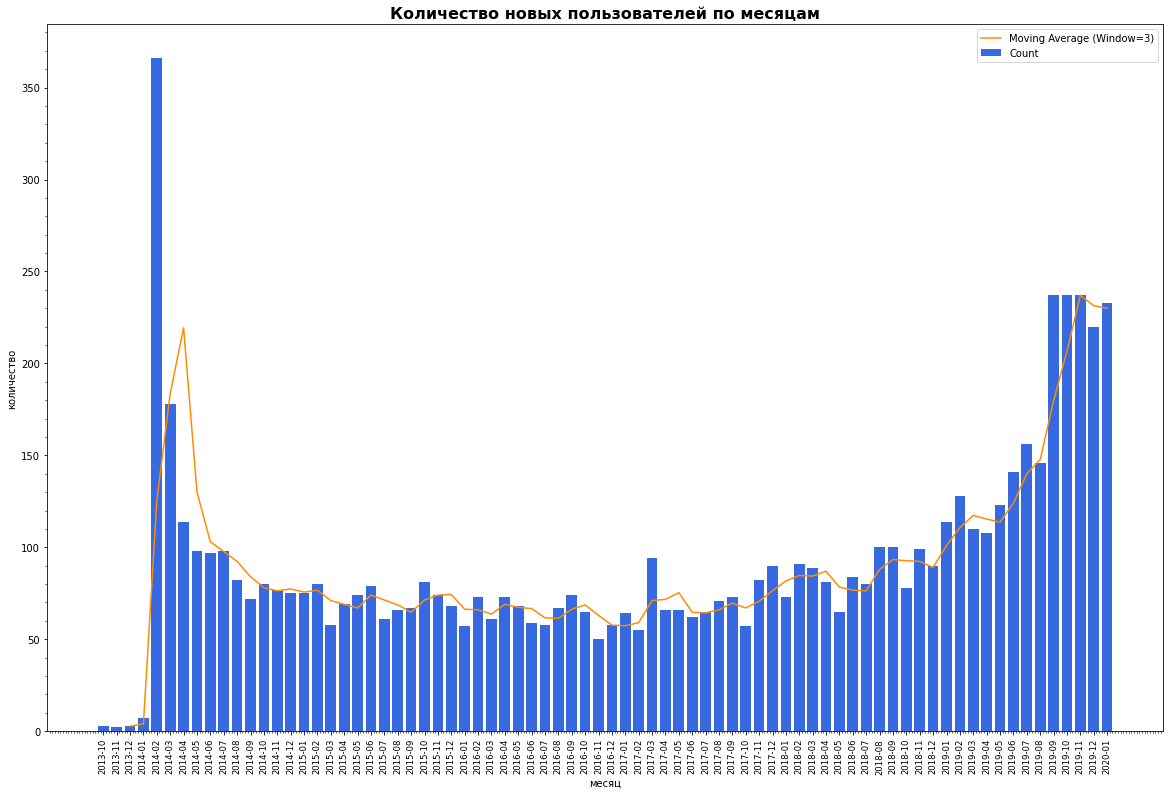

In [12]:
plot_bar(df_contract, 'begin_date', 'Количество новых пользователей по месяцам', indic = 1)

Заменим пропуски в столбце `end_date` на дату выгрузки данных **2020-02-01** и создадим целевую переменную (0 где признак `end_date` = **2020-02-01** –– клиент не в оттоке –– и 1 если другая дата –– клиент в оттоке):

In [13]:
df_contract.loc[df_contract['end_date'] == 'no', 'end_date'] = '2020-02-01'
df_contract['left'] = df_contract['end_date'].apply(lambda x: 0 if x == '2020-02-01' else 1)

In [14]:
df_contract['end_date'] = pd.to_datetime(df_contract['end_date'], format='%Y-%m-%d')
df_end = df_contract[df_contract['end_date'] != '2020-02-01']

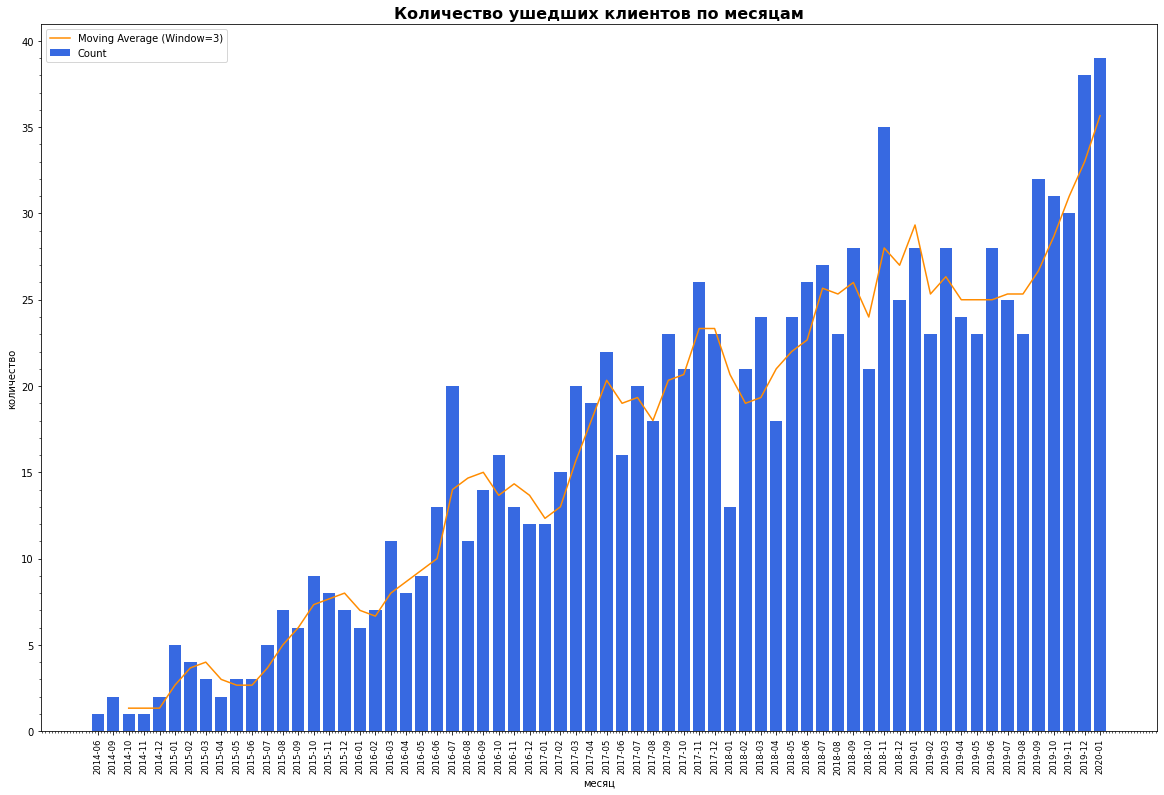

In [15]:
plot_bar(df_end, 'end_date', 'Количество ушедших клиентов по месяцам', indic = 1)

Пропуски:

In [16]:
df_contract.isna().sum()

customer_id          0
begin_date           0
end_date             0
type                 0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
left                 0
dtype: int64

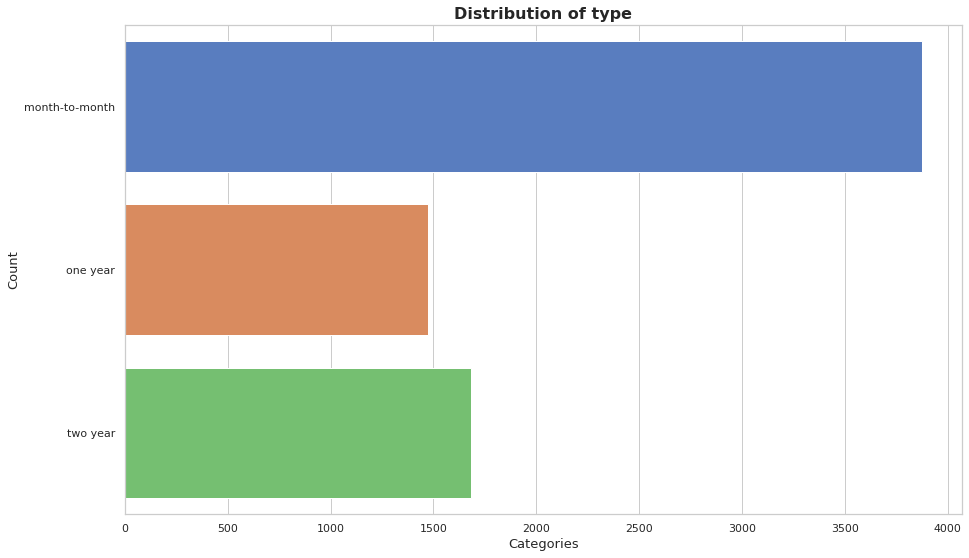

In [17]:
plot_count(df_contract, 'type', 'h')

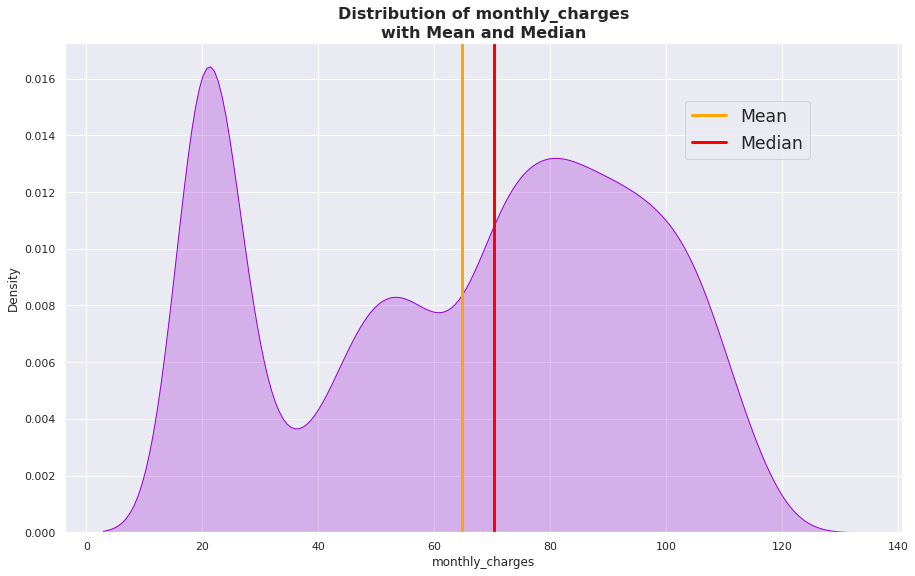

In [18]:
plot_numeric(df_contract, 'monthly_charges')

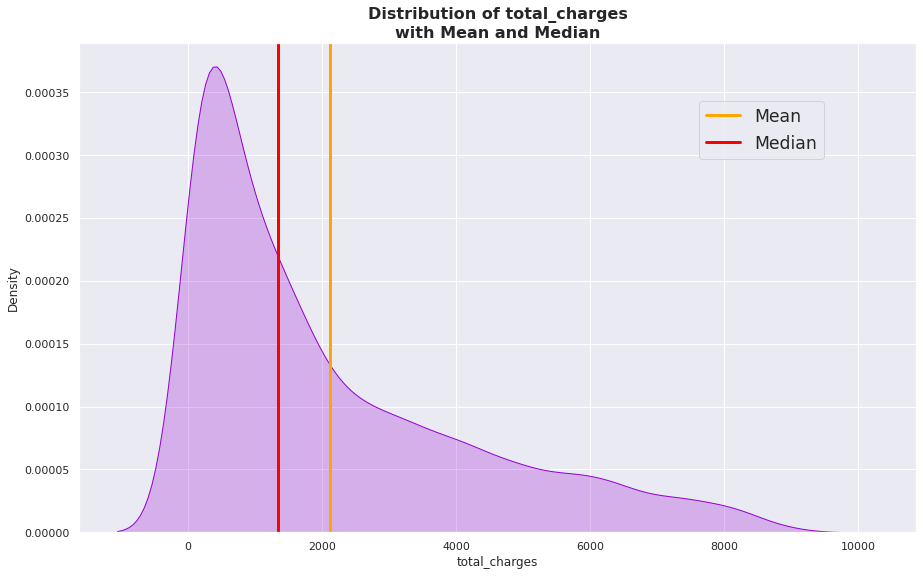

In [19]:
plot_numeric(df_contract, 'total_charges')

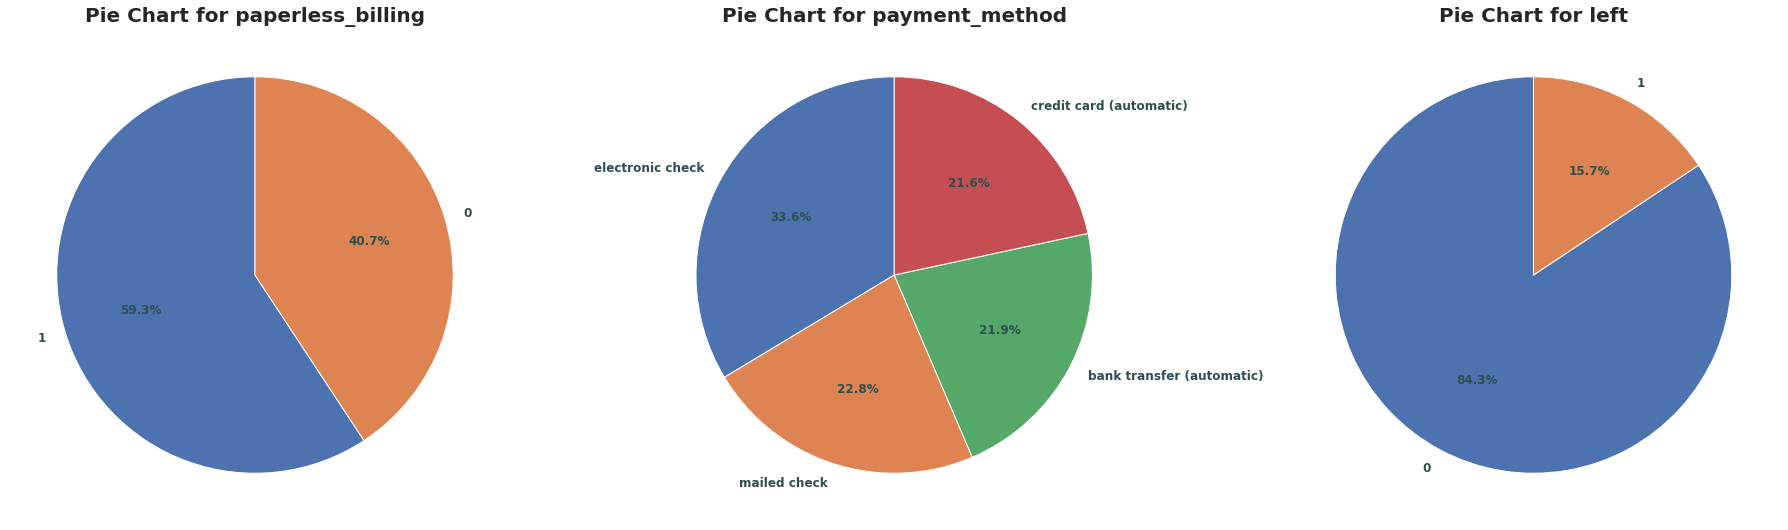

In [20]:
cat_columns = ['paperless_billing', 'payment_method', 'left']
plot_pie(df_contract, cat_columns)

**Вывод по первому датасету:**
* Открыли и изучили данные
* Пропуски были только в столбце `total_charges` в виде пробела –– 11 шт, мы от них избавились, потери некритичные
* Визуализировали числовые признаки. По столбцу `monthly_charges` видно, что есть пиковые точки в районе 20 и 80, медиана чуть больше чем среднее. По столбцу `total_charges`: пиковое значение также в районе 20 и далее график идет на спад
* Также посмотрели на категориальные признаки. Самый частый тип списаний  в столбце `payment_method` –– *month-to-month*. Чаще всего люди имеют электронный расчетный лист и чаще всего расплачиваются электронным чеком (33,6%). Практически равнозначно распределены оплаты картой, банковский перевод и *mailed check*.
* Создали новый признак `left`, означающий, ушел клиент или нет. Это и есть наша целевая переменная – **84% нулей и 16% единиц**. 
* Видим, что был сильный прирост новых клиентов в феврале 2014 года (можно удалить как аномалию), а потом такой же резкий спад и стагнация до 2018 года –– потом возрастающий тренд. Также мы видим, что стабильно увеличивается отток клиентов. Среднее растет, (можно поменять размер окна в функции, сделать, например, ma = 20 – будет более сглаженный график)

### Персональные данные клиента

In [21]:
df_pers = transform_and_binary_to_numeric(df_pers)

In [22]:
info(df_pers)

(7043, 5)

,customer_id,gender,senior_citizen,partner,dependents
0,7590-vhveg,0,0,1,0
1,5575-gnvde,1,0,0,0
2,3668-qpybk,1,0,0,0
3,7795-cfocw,1,0,0,0
4,9237-hqitu,0,0,0,0


,count,mean,std,min,25%,50%,75%,max
gender,7043.0,0.504756,0.500013,0.0,0.0,1.0,1.0,1.0
senior_citizen,7043.0,0.162147,0.368612,0.0,0.0,0.0,0.0,1.0
partner,7043.0,0.483033,0.499748,0.0,0.0,0.0,1.0,1.0
dependents,7043.0,0.299588,0.458110,0.0,0.0,0.0,1.0,1.0


In [23]:
df_pers.isna().sum()

customer_id       0
gender            0
senior_citizen    0
partner           0
dependents        0
dtype: int64

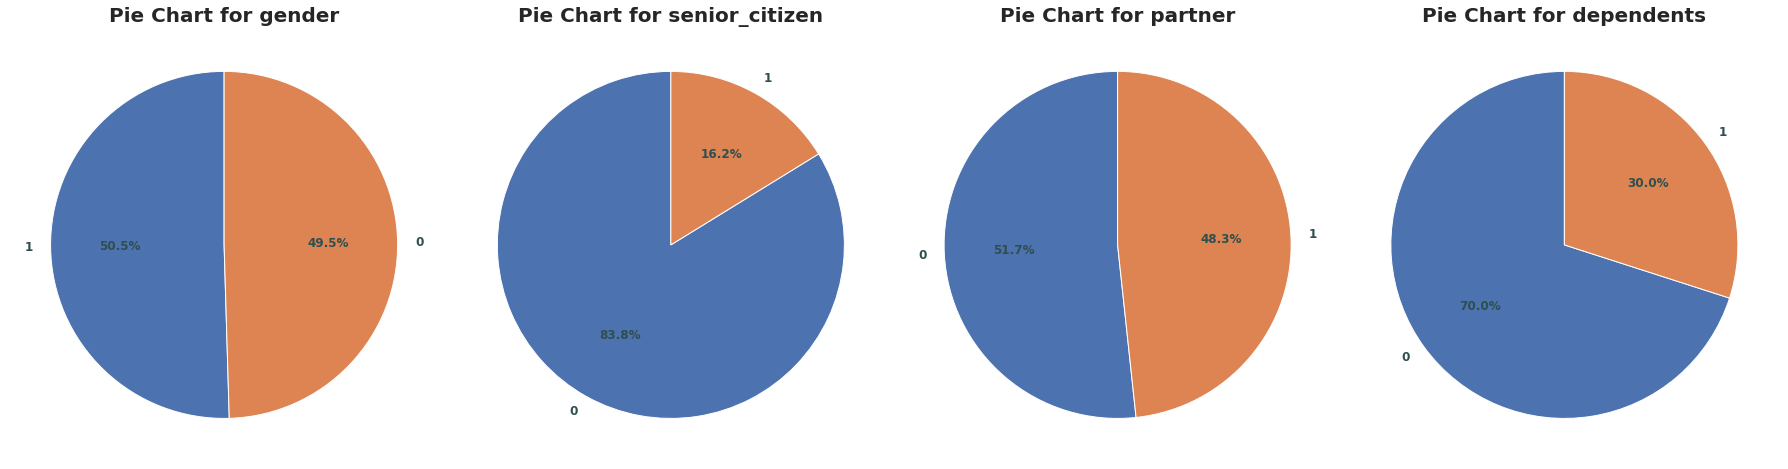

In [24]:
cat_cols = df_pers.drop('customer_id', axis = 1).columns.to_list()

plot_pie(df_pers, cat_cols)

**Вывод по второму датасету:**
* Пропусков нету
* Датасет состоит из категориальных признаков: гендер (1 если мужчина, 0 – женщина), индикатор дамми *senior_citizen*, *partner*, *dependents*. Видим, что мужчин и женщин примерно поровну, клиенты по большей части не *senior*. Чуть больше клиентов без супруга, и 70% клиентов без детей

### Информация об интернет-услугах

In [25]:
df_internet = transform_and_binary_to_numeric(df_internet)
info(df_internet)

(5517, 8)

,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
0,7590-vhveg,dsl,0,1,0,0,0,0
1,5575-gnvde,dsl,1,0,1,0,0,0
2,3668-qpybk,dsl,1,1,0,0,0,0
3,7795-cfocw,dsl,1,0,1,1,0,0
4,9237-hqitu,fiber optic,0,0,0,0,0,0


,count,mean,std,min,25%,50%,75%,max
online_security,5517.0,0.365960,0.481742,0.0,0.0,0.0,1.0,1.0
online_backup,5517.0,0.440276,0.496465,0.0,0.0,0.0,1.0,1.0
device_protection,5517.0,0.439007,0.496311,0.0,0.0,0.0,1.0,1.0
tech_support,5517.0,0.370491,0.482980,0.0,0.0,0.0,1.0,1.0
streaming_tv,5517.0,0.490665,0.499958,0.0,0.0,0.0,1.0,1.0
streaming_movies,5517.0,0.495197,0.500022,0.0,0.0,0.0,1.0,1.0


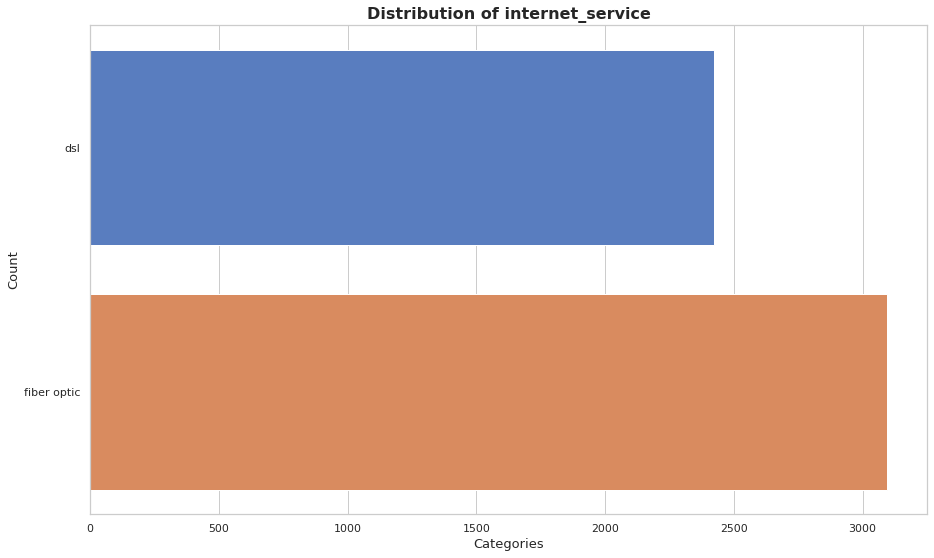

In [26]:
plot_count(df_internet, 'internet_service', 'h')

In [27]:
cat_columns = df_internet.drop(['customer_id', 'internet_service'], axis = 1).columns.to_list()

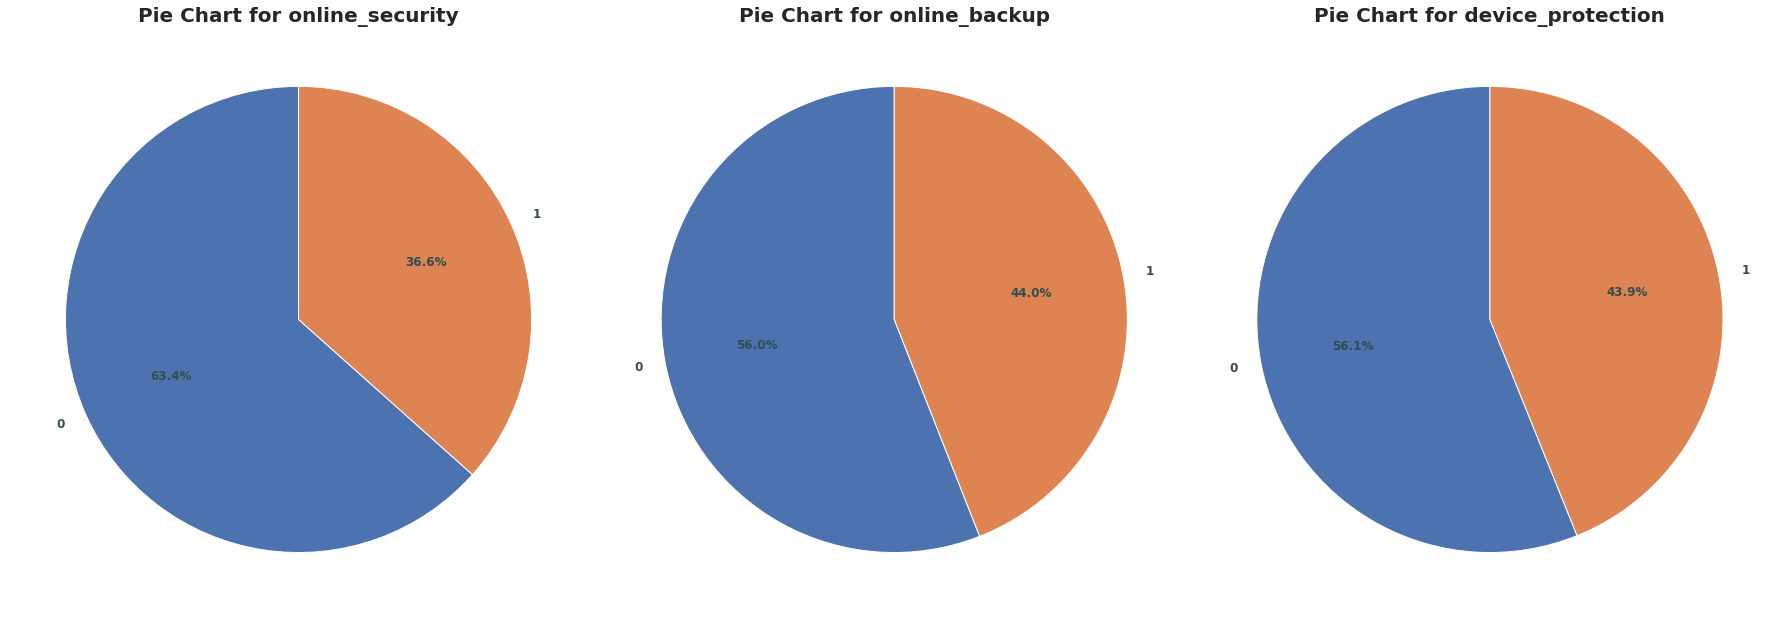

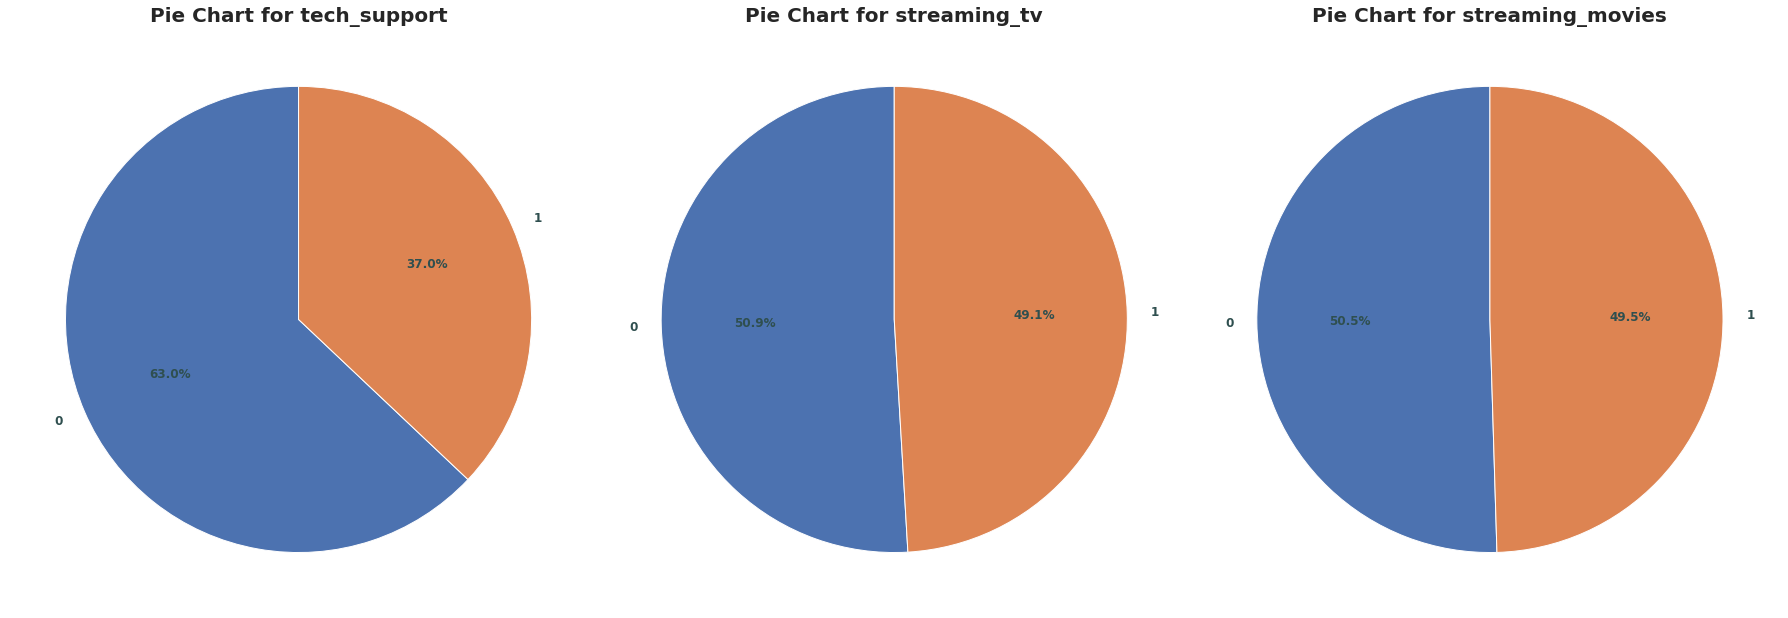

In [28]:
plot_pie(df_internet, cat_columns[0:3])
plot_pie(df_internet, cat_columns[3:])

**Вывод по третьему датасету:**
* Визуализировали бинарные признаки, а также тип интернет подключения
* Самое популярное интернет подключение – *fiber optic*
* В каждом из бинарных признаков преобладает ответ "Нет"

### Информация об услугах телефонии

In [29]:
df_phone = transform_and_binary_to_numeric(df_phone)
info(df_phone)

(6361, 2)

,customer_id,multiple_lines
0,5575-gnvde,0
1,3668-qpybk,0
2,9237-hqitu,0
3,9305-cdskc,1
4,1452-kiovk,1


,count,mean,std,min,25%,50%,75%,max
multiple_lines,6361.0,0.467065,0.498953,0.0,0.0,0.0,1.0,1.0


In [30]:
df_phone.isna().sum()

customer_id       0
multiple_lines    0
dtype: int64

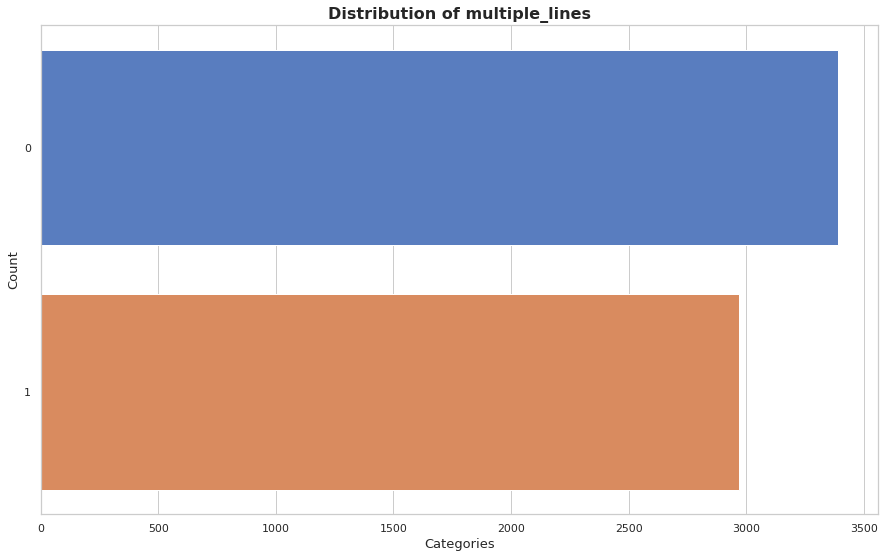

In [31]:
plot_count(df_phone, 'multiple_lines')

**Вывод по четвертому признаку:**
* Визуализировали значения признака *multiple_lines*. Чуть больше людей не используют несколько линий, нежели используют
* Пропусков нету

### Вывод по первичному анализу
* Посмотрели распределение по признакам, привели некоторые столбцы к нужному типу, удалили пропуски
* Датасеты разных строк, поэтому, чтобы ничего не упустить, объединять будем методом **outer**
* Пропусков было совсем немного (11 шт), но после объединения их будет достаточно

# 3 Все в одном месте
* Объединим все данные в одном датасете
* Разделим выборки
* Стандартизируем и закодируем выборки

## Объединяем датасеты

In [32]:
df_internet.shape, df_phone.shape, df_pers.shape, df_contract.shape

((5517, 8), (6361, 2), (7043, 5), (7032, 9))

In [33]:
df = df_contract.merge(
    df_pers, on = 'customer_id', how = 'left'
).merge(
    df_internet, on = 'customer_id', how = 'left'
).merge(
    df_phone, on = 'customer_id', how = 'left'
)

df

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,left,gender,...,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-vhveg,2020-01-01,2020-02-01,month-to-month,1,electronic check,29.85,31.04,0,0,...,1,0,dsl,0.0,1.0,0.0,0.0,0.0,0.0,NaN
1,5575-gnvde,2017-04-01,2020-02-01,one year,0,mailed check,56.95,2071.84,0,1,...,0,0,dsl,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2,3668-qpybk,2019-10-01,2020-02-01,month-to-month,1,mailed check,53.85,226.17,0,1,...,0,0,dsl,1.0,1.0,0.0,0.0,0.0,0.0,0.0
3,7795-cfocw,2016-05-01,2020-02-01,one year,0,bank transfer (automatic),42.30,1960.60,0,1,...,0,0,dsl,1.0,0.0,1.0,1.0,0.0,0.0,NaN
4,9237-hqitu,2019-09-01,2020-02-01,month-to-month,1,electronic check,70.70,353.50,0,0,...,0,0,fiber optic,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027,6840-resvb,2018-02-01,2020-02-01,one year,1,mailed check,84.80,2035.20,0,1,...,1,1,dsl,1.0,0.0,1.0,1.0,1.0,1.0,1.0
7028,2234-xaduh,2014-02-01,2020-02-01,one year,1,credit card (automatic),103.20,7430.40,0,0,...,1,1,fiber optic,0.0,1.0,1.0,0.0,1.0,1.0,1.0
7029,4801-jzazl,2019-03-01,2020-02-01,month-to-month,1,electronic check,29.60,325.60,0,0,...,1,1,dsl,1.0,0.0,0.0,0.0,0.0,0.0,NaN
7030,8361-ltmkd,2019-07-01,2020-02-01,month-to-month,1,mailed check,74.40,520.80,0,1,...,1,0,fiber optic,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## Обрабатываем пропуски

Очевидно было, что придется работать с большим кол-вом пропусков. Тут мы ничего не можем сделать, так как удалять данные непозволительно, но и так работать тоже нельзя. Придется заполнить третьей категорией – 'No'. Там, где пропусков 11, скорее всего в 11 строках все эти колонки имеют пропущенные значения:

In [37]:
df = df[df['type'].notna()]
df.isna().sum()

customer_id             0
begin_date              0
end_date                0
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
left                    0
gender                  0
senior_citizen          0
partner                 0
dependents              0
internet_service     1520
online_security      1520
online_backup        1520
device_protection    1520
tech_support         1520
streaming_tv         1520
streaming_movies     1520
multiple_lines        680
dtype: int64

In [38]:
df['left'].value_counts(normalize = True).round(2)

0    0.84
1    0.16
Name: left, dtype: float64

Заполним все оставшиеся признаки новым значением **'No'**:

In [39]:
cols_no = ['internet_service', 'online_security', 'online_backup','device_protection', 'tech_support', 'streaming_tv','streaming_movies', 'multiple_lines']

In [40]:
df[cols_no] = df[cols_no].fillna('No')

In [41]:
import seaborn as sns

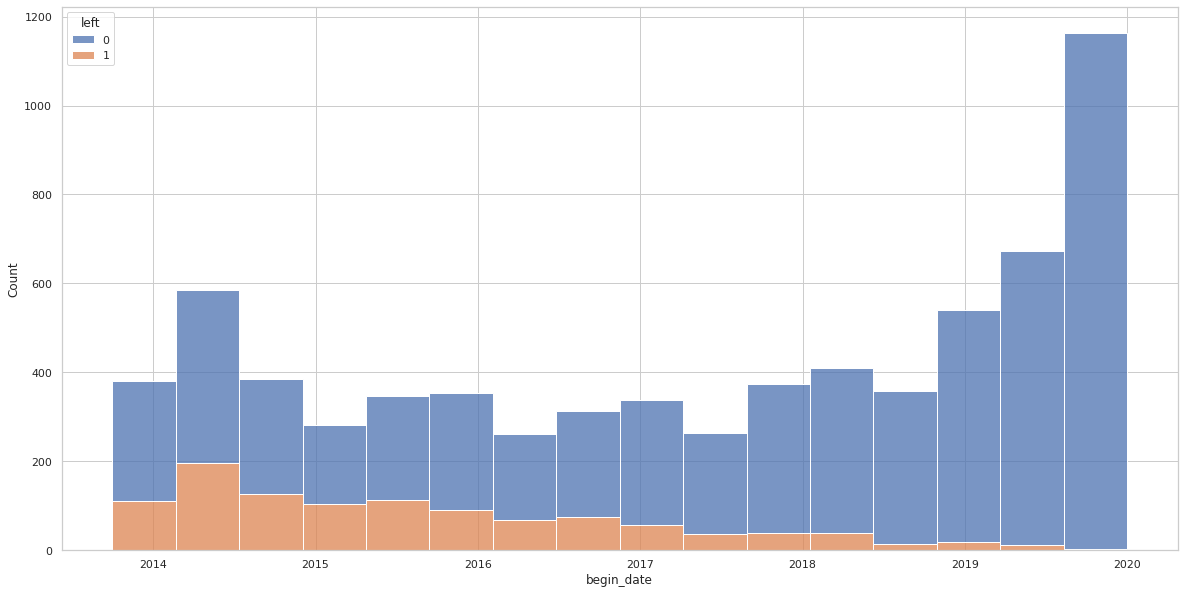

In [42]:
plt.figure(figsize = (20,10))
sns.histplot(df, x='begin_date', hue='left', multiple="stack")
plt.show();

Можно заметить, что на текущий момент в основном ушли клиенты, кто подключался в 2014-2016 годах. Более того, меньше клиентов, кто подключился в 2017-2018 годах –– это вплоне логично. Среди старых клиентов гораздо больше ушедших, а большинство новых клиентов пока пользуются сервисом компании  

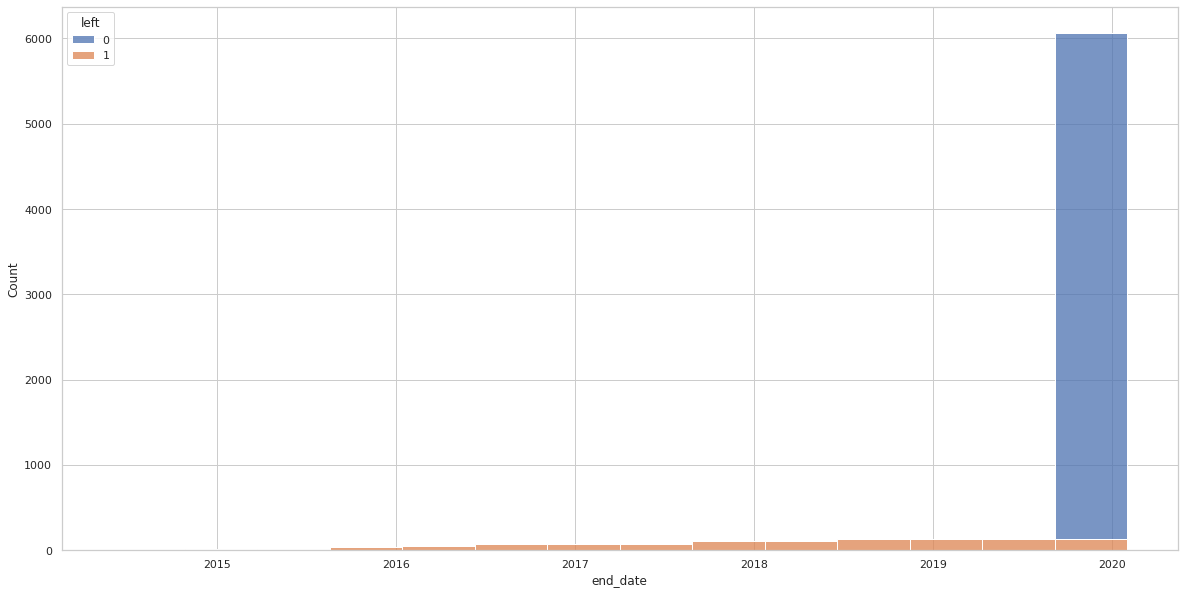

In [43]:
plt.figure(figsize = (20,10))
sns.histplot(df, x='end_date', hue='left', multiple="stack")
plt.show();

Можно не обращать внимание на "заглушку" в виде даты '2020-02-01', которую мы поставили в значения столбца `end_date`, где стояло 'No'. По графику видно, что отток увеличивался логично –– больше клиентов в компании, соответственно больше уходит

## Feature Engineering
* Длительность контракта в месяцах `month`
* Удалим `end_date`
* Средняя трата в месяц на клиента: `mean_charges_per_month` = `total_charges` / `month`
* Добавим дамми переменную `partner` * `dependents` = `partner_dependents`
* Количество сервисов, которые использовались: `total_services`

In [47]:
df['months'] = (df['end_date'] - df['begin_date']) / np.timedelta64(1, 'M')

In [48]:
df = df.drop('end_date', axis = 1)

Видим, что у клиента в 1816 строке есть `total_charges` = 87.01 и `monthly_charges` = 85.3, но длительность пользования сервисом – 0 месяцев. Скорее всего, какая-то ошибка в записи данных, удалим эту строку`

In [49]:
df = df[df['months'] != 0]

In [50]:
df['mean_charges_per_month'] = df['total_charges'] / df['months']
df['mean_charges_per_month'] = pd.to_numeric(df['mean_charges_per_month'], errors='coerce')

df['mean_charges_per_month'] = df['mean_charges_per_month'].round(2)

In [51]:
df['senior_citizens_dependents'] = df['senior_citizen'] * df['dependents']

In [52]:
df['total_services'] = df[['multiple_lines', 'online_security', 'online_backup', \
                                    'device_protection', 'tech_support', 'streaming_tv', \
                                    'streaming_movies']].apply(lambda x: x.eq(1.0).sum(), axis=1)

In [53]:
df['left'] = df['left'].astype('int')
df['paperless_billing'] = df['paperless_billing'].astype('int') 

## Исследовательский анализ
Исследуем корреляцию между признаками, проверим наличие мультиколлинеарности и сделаем вывод по фильтрации признаков

In [54]:
from phik import phik_matrix

interval columns not set, guessing: ['paperless_billing', 'monthly_charges', 'total_charges', 'left', 'gender', 'senior_citizen', 'partner', 'dependents', 'year', 'months', 'mean_charges_per_month', 'senior_citizens_dependents', 'total_services']


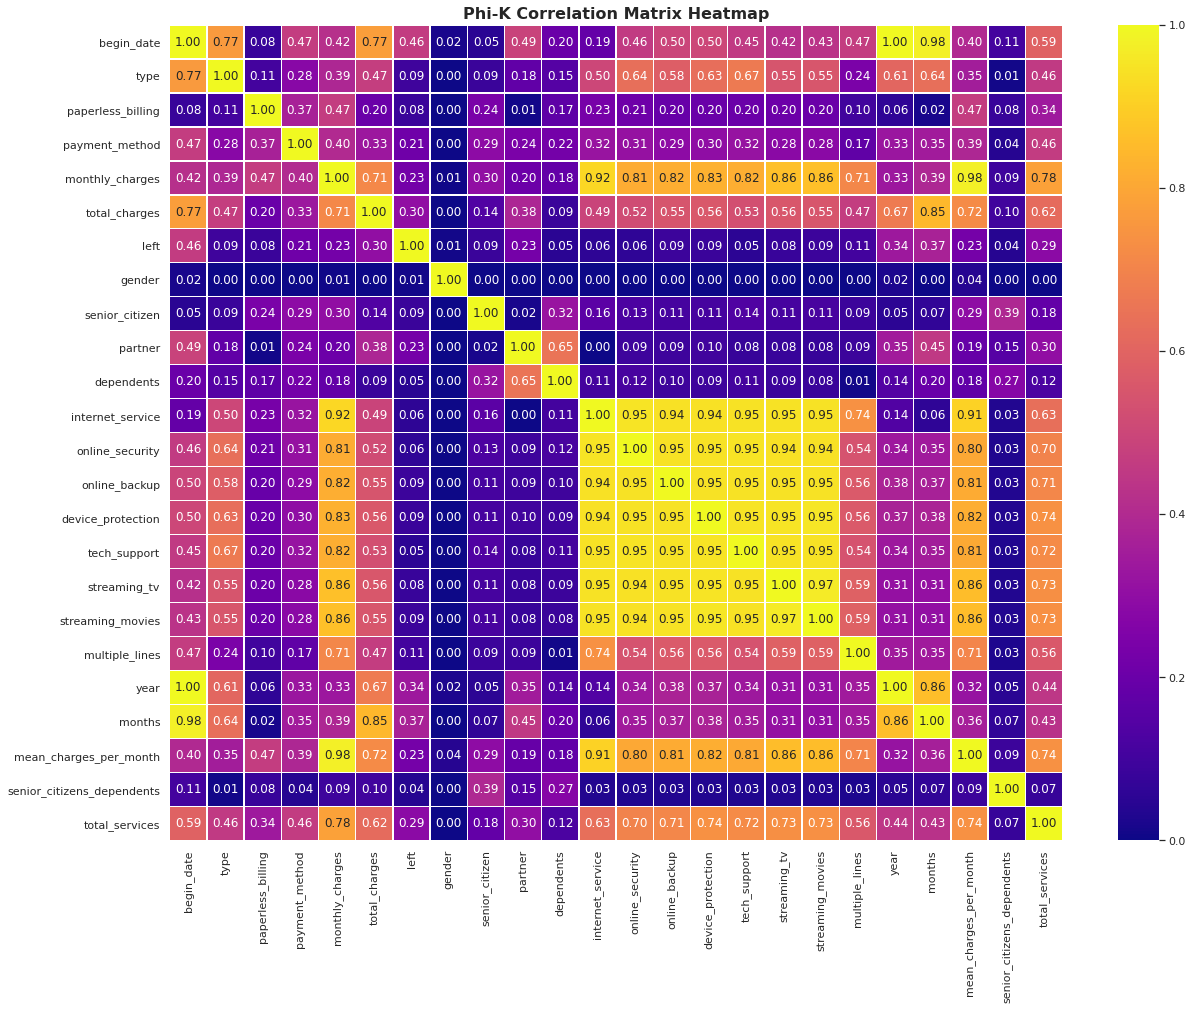

In [55]:
plot_phik(df.drop(columns='customer_id'))

Корреляция каждого признака с целевой переменной:

interval columns not set, guessing: ['paperless_billing', 'monthly_charges', 'total_charges', 'left', 'gender', 'senior_citizen', 'partner', 'dependents', 'year', 'months', 'mean_charges_per_month', 'senior_citizens_dependents', 'total_services']


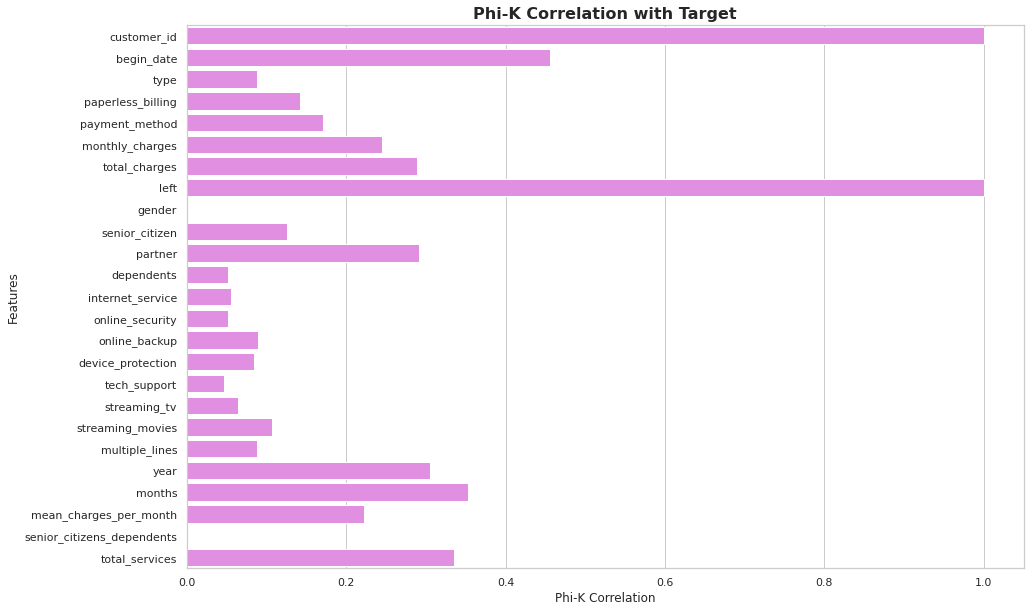

In [56]:
df_sample = df.sample(frac=0.1)

phik_matrix_result = phik_matrix(df_sample)

target_correlations = phik_matrix_result.loc['left']

plt.figure(figsize=(15, 10))
sns.barplot(x=target_correlations.values, y=target_correlations.index, color='violet')
plt.title('Phi-K Correlation with Target', fontsize=16, fontweight='bold')
plt.xlabel('Phi-K Correlation')
plt.ylabel('Features')
plt.show()

Нужно удалить сервисы. Причина тому –– мультиколлинеарность между признаками, и не особо сильный вклад в корреляцию с целевым признаком. Зададим correlation threshold > 0.1: стоит удалить гендер (корреляция 0), *senior_citizens_dependents, paperless_billing, online_security,*... все сервисы 

In [57]:
df = df.drop(['senior_citizens_dependents','streaming_movies',
              'streaming_tv', 'tech_support', 'device_protection',
              'online_backup', 'online_security', 'internet_service',
              'dependents', 'gender'], axis = 1)

df

,customer_id,begin_date,type,paperless_billing,payment_method,monthly_charges,total_charges,left,senior_citizen,partner,multiple_lines,year,months,mean_charges_per_month,total_services
0,7590-vhveg,2020-01-01,month-to-month,1,electronic check,29.85,31.04,0,0,1,No,2020,1.018501,30.48,1
1,5575-gnvde,2017-04-01,one year,0,mailed check,56.95,2071.84,0,0,0,0.0,2017,34.037660,60.87,2
2,3668-qpybk,2019-10-01,month-to-month,1,mailed check,53.85,226.17,0,0,0,0.0,2019,4.041151,55.97,2
3,7795-cfocw,2016-05-01,one year,0,bank transfer (automatic),42.30,1960.60,0,0,0,No,2016,45.044046,43.53,3
4,9237-hqitu,2019-09-01,month-to-month,1,electronic check,70.70,353.50,0,0,0,0.0,2019,5.026797,70.32,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027,6840-resvb,2018-02-01,one year,1,mailed check,84.80,2035.20,0,0,1,1.0,2018,23.984065,84.86,6
7028,2234-xaduh,2014-02-01,one year,1,credit card (automatic),103.20,7430.40,0,0,1,1.0,2014,71.985051,103.22,5
7029,4801-jzazl,2019-03-01,month-to-month,1,electronic check,29.60,325.60,0,0,1,No,2019,11.072096,29.41,1
7030,8361-ltmkd,2019-07-01,month-to-month,1,mailed check,74.40,520.80,0,1,1,1.0,2019,7.063800,73.73,1


interval columns not set, guessing: ['paperless_billing', 'monthly_charges', 'total_charges', 'left', 'senior_citizen', 'partner', 'year', 'months', 'mean_charges_per_month', 'total_services']


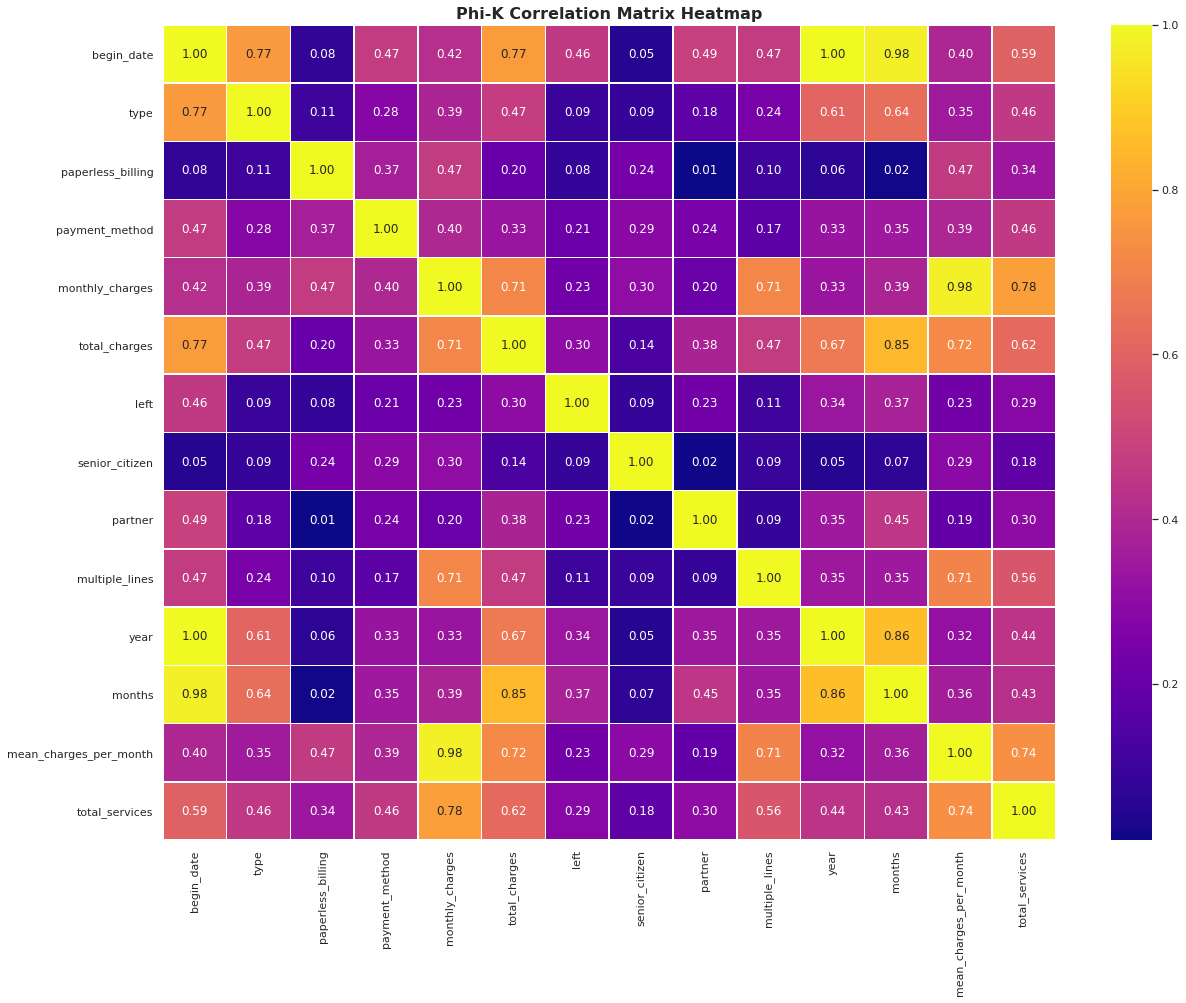

In [58]:
plot_phik(df.drop(columns='customer_id'))

In [59]:
df = df.drop(['customer_id', 'senior_citizen', 'paperless_billing'], axis = 1)
df

,begin_date,type,payment_method,monthly_charges,total_charges,left,partner,multiple_lines,year,months,mean_charges_per_month,total_services
0,2020-01-01,month-to-month,electronic check,29.85,31.04,0,1,No,2020,1.018501,30.48,1
1,2017-04-01,one year,mailed check,56.95,2071.84,0,0,0.0,2017,34.037660,60.87,2
2,2019-10-01,month-to-month,mailed check,53.85,226.17,0,0,0.0,2019,4.041151,55.97,2
3,2016-05-01,one year,bank transfer (automatic),42.30,1960.60,0,0,No,2016,45.044046,43.53,3
4,2019-09-01,month-to-month,electronic check,70.70,353.50,0,0,0.0,2019,5.026797,70.32,0
...,...,...,...,...,...,...,...,...,...,...,...,...
7027,2018-02-01,one year,mailed check,84.80,2035.20,0,1,1.0,2018,23.984065,84.86,6
7028,2014-02-01,one year,credit card (automatic),103.20,7430.40,0,1,1.0,2014,71.985051,103.22,5
7029,2019-03-01,month-to-month,electronic check,29.60,325.60,0,1,No,2019,11.072096,29.41,1
7030,2019-07-01,month-to-month,mailed check,74.40,520.80,0,1,1.0,2019,7.063800,73.73,1


# 4 Подготовка данных к обучению

### Разделение на тренировочную и тестовую выборки
Размер выборки – 0.25. Разделим данные и проверим их размерность

In [61]:
test_size = 0.25
rndst = 131123

In [62]:
target = df['left']
features = df.drop('left', axis=1)

In [63]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.25, random_state = rndst)

In [64]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((5274, 11), (5274,), (1758, 11), (1758,))

### Кодирование
Численные признаки стандартизируем методом **StandardScaler**, столбец **type** нужно закодировать принципом **Ordinal Encoder**, тк признаки имеют порядковую важность, а значения в столбце **payment_method** преобразуем методом **OHE**

In [65]:
col_ord = ['type']
col_ohe = ['payment_method']
num_col = ['monthly_charges', 'total_charges','total_services', 'mean_charges_per_month', 'months']

In [66]:
X_train_scaled, X_test_scaled = scaling(X_train, X_test, num_col)

In [67]:
X_train_ord, X_test_ord = ordinal(X_train, X_test, col_ord)

In [68]:
X_train_ohe, X_test_ohe = ohe(X_train, X_test, col_ohe)

### Собираем все признаки вместе

In [69]:
X_train_ohe = X_train_ohe.drop('index', axis = 1) 

In [70]:
new_col = X_train_ohe.columns.to_list()
new_col = [col for col in new_col if col not in X_train.columns.to_list()]
new_col

['x0_credit card (automatic)', 'x0_electronic check', 'x0_mailed check']

In [71]:
X_train_ = pd.DataFrame()
X_train_[num_col] = X_train_scaled[num_col]
X_train_[col_ord] = X_train_ord[col_ord]
X_train_[new_col] = X_train_ohe[new_col]
X_train_

,monthly_charges,total_charges,total_services,mean_charges_per_month,months,type,x0_credit card (automatic),x0_electronic check,x0_mailed check
0,0.809980,1.186058,2.218651,0.730513,1.001462,2.0,0.0,0.0,1.0
1,-0.195154,-0.788921,-0.231752,-0.070270,-1.009626,1.0,0.0,1.0,0.0
2,-1.485325,-0.915272,-1.211913,-1.485870,-0.920015,0.0,0.0,0.0,1.0
3,0.769974,2.077214,2.218651,0.779996,1.893157,2.0,1.0,0.0,0.0
4,0.488270,-0.815847,-0.721833,0.407095,-1.100705,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...
5269,0.814980,-0.389488,0.258328,0.846944,-0.698194,0.0,0.0,1.0,0.0
5270,-0.846907,-0.835687,0.258328,-0.884313,-0.920015,1.0,0.0,0.0,1.0
5271,-1.335305,-0.980133,-1.211913,-1.362971,-1.234386,0.0,1.0,0.0,0.0
5272,0.511607,-0.605819,-0.721833,0.558778,-0.875945,0.0,0.0,0.0,1.0


In [72]:
X_test_ = pd.DataFrame()
X_test_[num_col] = X_test_scaled[num_col]
X_test_[col_ord] = X_test_ord[col_ord]
X_test_[new_col] = X_test_ohe[new_col]
X_test_

,monthly_charges,total_charges,total_services,mean_charges_per_month,months,type,x0_credit card (automatic),x0_electronic check,x0_mailed check
0,1.161693,-0.768194,0.748409,1.056842,-1.100705,0.0,0.0,1.0,0.0
1,-1.475324,-0.993669,-1.211913,-1.483283,-1.279925,0.0,0.0,1.0,0.0
2,-0.351841,-0.413296,-0.231752,-0.399186,-0.294213,0.0,0.0,1.0,0.0
3,0.611620,0.804266,1.728570,0.542607,0.729694,2.0,0.0,0.0,0.0
4,-0.825238,-0.662225,0.258328,-0.856175,-0.518973,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...
1753,0.368254,-0.183202,-0.721833,0.397393,-0.339753,1.0,1.0,0.0,0.0
1754,-1.516996,-0.865977,-1.211913,-1.525327,-0.654123,0.0,1.0,0.0,0.0
1755,0.478269,0.146502,-0.231752,0.563953,-0.028321,0.0,0.0,1.0,0.0
1756,0.331583,-0.656954,-0.721833,0.495712,-0.924423,0.0,0.0,0.0,0.0


Все признаки приведены в порядок и собраны в новых датасетах **X_train_, X_test_**. Теперь можем приступать к обучению моделей

## Инициализация и обучение моделей

На новых сформированных выборках обучим следующие модели: **LogisticRegression, RandomForestClassifier, CatBoostClassifier**. Затем по данным кросс-валидации сравним эти модели и посчитаем метрику **AUC-ROC** на тестовой выборке

### Logistic Regression

In [73]:
params_lr = {'class_weight' : ['balanced'], 
             'max_iter' : range(1,1000, 100),
             'C' : [0.5, 1.0, 1.5]}

lr = LogisticRegression(random_state = rndst, solver = 'liblinear')
lr_cv = RandomizedSearchCV(lr, param_distributions = params_lr, scoring='roc_auc', verbose=1, cv = 5)
lr_cv.fit(X_train_, y_train)

print('Лучший ROC-AUC на тренировочной выборке:', lr_cv.best_score_)
print('Лучшие параметры модели на тренировочной выборке:', lr_cv.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Лучший ROC-AUC на тренировочной выборке: 0.7309417660889558
Лучшие параметры модели на тренировочной выборке: {'max_iter': 801, 'class_weight': 'balanced', 'C': 0.5}


У модели **Logistic Regression** метрика на тренировочной выборке составила 73%, что не очень хороший результат

### RandomForestClassifier

In [74]:
params_rf = {'n_estimators': range(10,80,10),
               'criterion': ['entropy', 'gini'],
               'max_depth': range(1,15,4),
               'min_samples_split': [1,2,5],
               'min_samples_leaf': [2,4,8],
               'bootstrap': [True, False]}

rf = RandomForestClassifier(random_state = rndst)
rf_cv = RandomizedSearchCV(rf, param_distributions = params_rf, scoring='roc_auc', verbose=1, cv = 10)
rf_cv.fit(X_train_, y_train)

print('Best ROC-AUC on train sample:', rf_cv.best_score_)
print('Best parameters on train sample:', rf_cv.best_params_)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Best ROC-AUC on train sample: 0.8206516260695901
Best parameters on train sample: {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 9, 'criterion': 'entropy', 'bootstrap': True}


**RandomForestClassifier** показывает хороший результат 82%

### CatBoostClassifier

In [75]:
params_cb = {'learning_rate': [0.03, 0.06],
        'max_depth':[1, 5, 7],
        'l2_leaf_reg': [2, 3, 4],
        'border_count' : [128],
        'n_estimators' : [200, 500, 1000],
        'boosting_type': ['Ordered', 'Plain']}
class_weights = {1: 1, 0: 5.31}
cb = CatBoostClassifier(random_state = rndst, silent = True, class_weights = class_weights)
cb_cv = RandomizedSearchCV(cb, param_distributions = params_cb, scoring='roc_auc', cv = 10)
cb_cv.fit(X_train_, y_train)

print('Best ROC-AUC on train sample:', cb_cv.best_score_)
print('Best parameters on train sample:', cb_cv.best_params_)

Best ROC-AUC on train sample: 0.894681258256458
Best parameters on train sample: {'n_estimators': 1000, 'max_depth': 5, 'learning_rate': 0.06, 'l2_leaf_reg': 2, 'border_count': 128, 'boosting_type': 'Plain'}


In [76]:
best_model = cb_cv.best_estimator_

In [77]:
pred = best_model.predict(X_test_)
pred_prob = best_model.predict_proba(X_test_)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, pred_prob)
auc_roc = roc_auc_score(y_test, pred_prob)
print('AUC-ROC модели Catboost на тестовой выборке:',auc_roc)

AUC-ROC модели Catboost на тестовой выборке: 0.9048757888410299


Метрика **AUC-ROC** на модели **CatBoostClassifier** достигла 90,4% при параметрах *n_estimators* = 1000, *max_depth* = 5, *learning_rate* = 0.06, *l2_leaf_reg* = 4, *border_count* = 128, *boosting_type* = 'Ordered'

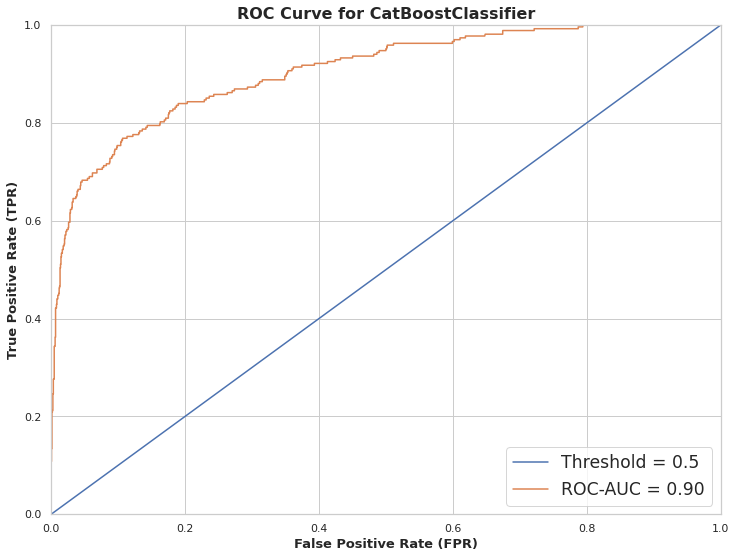

In [78]:
plot_roc_curve(fpr, tpr, thresholds, auc_roc)

### Вывод по моделям
* Все модели обучены и на кросс-валидации рассчитана метрика **AUC-ROC**
* Модель **LogisticRegression** показала результат в районе 70%, **RandomForestClassifier** –– 82%, **CatBoostClassifier** –- 89.25%
* Лучшую модель **CatBoostClassifier** проверили на тестовой выборке и рассчитали метрику: 90.3%

# 6 Отчет

**Проект состоит из следующих этапов:** 

- Введение
- Изучение данных
- Обработка данных
- Исследование задачи

Структура работы определена целью исследования – **прогнозировать отток клиентов**.


**0.	Введение.**

На данном этапе была сформирована цель исследования, представлено описание услуг заказчика, а также описание данных, состоящих из четырех датасетов.

**1.	Изучение данных**

- Импортированы необходимые библиотеки и метрики, рассмотрены каждые из датасетов отдельно. 
- Данные изучены и визуализированы распределения числовых и категориальных признаков. Визуализация проводилась с помощью построения круговых диаграмм, гистограмм и других графиков.
- На этом этапе был сформулирован предварительный план исследования. Ключевым показателем для модели установлен AUC-ROC=> 0.85.

**2.	Обработка данных**

- После первичного изучения провелась предобработка данных, которая включала в себя: преобразование и создание новых признаков, удаление ненужных признаков, удаление и обработка пропусков. Дубликатов обнаружено не было.

- Добавлен целевой признак – факт отказа клиента от обслуживания. Также добавлен признак, отражающий продолжительность пользования клиентом услуг компании. Исследовано распределение целевой переменной – 1 : 5.3.

**3.	Исследование задачи**

- На этапе исследовательского анализа была изучена взаимосвязь всех признаков с помощью тепловой карте *phik*. Была обнаружена мультиколлинеарность между признаками, вследствие чего данные лишились нескольких столбцов. 
- На данном этапе были выбраны следующие модели для обучения: **LogisticRegression, RandomForestClassifier, CatBoostClassifier**.
- Размер тестовой выборки определили в 25% от исходных данных.
- Признаки были масштабированы, к каждой из выборок были применены техники кодирования с помощью методов **OHE, StandardScaler** и **OrdinalEncoder**. 
- Для поиска лучших параметров модели и экономии нашего времени воспользовались **RandomizedSearchCV**.
- Модели сравнивались между собой на кросс-валидации по метрике **ROC-AUC**

- Лучший показатель на тренировочной выборке у модели **CatBoostClassifier** ROC-AUC = 89%. 
```
Лучшие гиперпараметры: 
border_count=128, 
learning_rate=0.1, 
max_depth=2, 
n_estimators=2000.**
```

- Проверка качества модели на тестовой выборке показала **ROC-AUC = 90.3%**, что считается удовлетворительным результатом.
 
**Заключение: модель CatBoostClassifier с указанными выше гиперпараметрами является наиболее подходящей. для прогнозирования оттока клиентов**

# 7 Бонус: рекоммендации заказчику

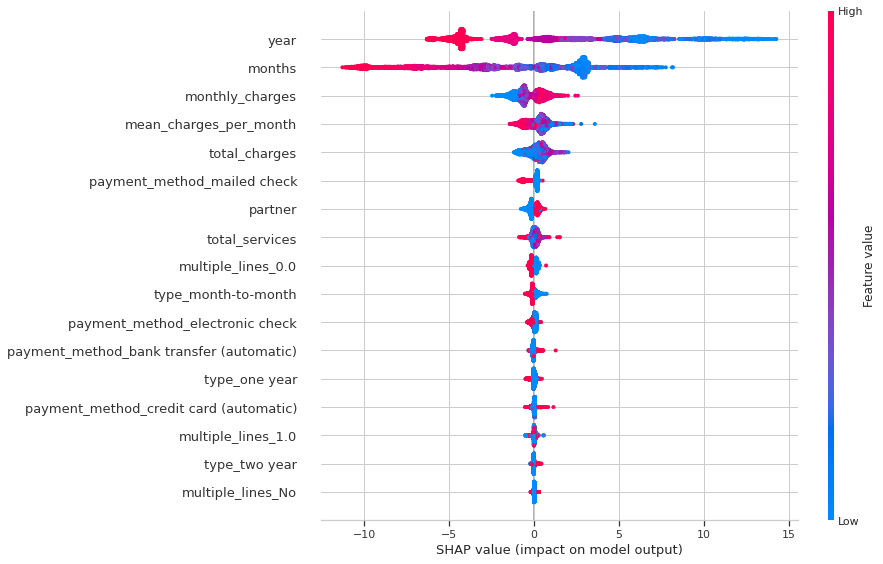

In [79]:
catboost_params = cb_cv.best_params_
model = CatBoostClassifier(**catboost_params, silent = True)
return_model_for_shap(X_train, y_train, model)

```
На данном графике видны все признаки, которые использовались для работы с моделью CatBoostClassifier, нашей лучшей моделью. Признаки расположены сверху вниз по их важности в определении оттока клиента. Лучше всего 
себя показывают следующие признаки: months, total_charges, partner, payment_method (закодированный в дамми). Также можно выделить важность нами созданных признаков: total_services и mean_charges_per_month. Заказчику 
стоит обращать внимание на эти показатели. Видим вполне логичные результаты по первым двум признакам: 
очевидно, что чем дольше клиент пользуется сервисом, тем меньше вероятность его оттока, а также чем меньше с него берут в целом денег, тем ему это более по нраву (также верно и для mean_charges_per_month). Видно, что чем меньше услуг подключено у клиента, тем меньше он склонен к оттоку, и наоборот. Возможно, заказчику стоит 
задуматься о качестве предоставляемых услуг, если с увеличением подключений растет вероятность оттока. Также 
заметим, что нет смысла в каких-то семейных предложениях или акциях для парочек, так как наличие партнера наоборот склоняет клиента к оттоку. 
```